<a href="https://colab.research.google.com/github/janchorowski/nn_assignments/blob/nn18/lectures/15_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Generative Adversarial Network (GAN), introduced in [Goodfellow 2014](https://arxiv.org/abs/1406.2661) learns to generate data by training two neural networks:
1. a generator network, that takes a random seed and produces fake data
2. and a discriminator that tell apart the fake and real data.

Training oscillates between:
1. generating a batch of fake data, mixing real ones and training the discriminator using the typical classification loss

$$
\text{fake} = g(z)
$$
$$
D_{loss} = -\sum_{x\in real}log(p_d(x)) - \sum_{x\in fake}log(1 - p_d(x))
$$

2. training the generator to fool the discriminator, that is to maximize its output for fake data

$$
D_{gen} =  - \sum_{z}log(1 - p_d(g(z)))
$$

In this way, the discriminator guides the generator to yield samples which are nondistinguishable by a neural net from the real data.

In practice, GAN training requires careful design: the discrimantor is typically  a weaker model than the generator, and moreover a non-saturating generator criterion is used which maximizes

$$
D'_{gen} =  \sum_{z}log(p_d(g(z)))
$$

GANs yield samples which are often very good looking, at the expense of coverage of the whole data distribution (that is GANs concentrate on modeling a few modes of the data distribution $x$, rather than on modelling all possible samples). This often yields visually appealing samples.

The demo below presents a basic GAN for the MNIST data. Plsease observe, that we use the alternative generator training criterin $D'_{gen}$ and that the generator has more neurons, and smaller weight decay than the generator. Without these design choices, the model doesn't train.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
%matplotlib inline

In [0]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

Downloading...
From: https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR
To: /content/cifar.npz
185MB [00:03, 50.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU
To: /content/mnist.npz
55.4MB [00:00, 108MB/s] 


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5642e5bf0000 @  0x7f402ef9e2a4 0x56428e93bf18 0x56428ea2fa85 0x56428e94f4ca 0x56428e954232 0x56428e94cd0a 0x56428e9545fe 0x56428e94cd0a 0x56428e9545fe 0x56428e94cd0a 0x56428e9545fe 0x56428e94cd0a 0x56428e954c38 0x56428e94cd0a 0x56428e9545fe 0x56428e94cd0a 0x56428e9545fe 0x56428e954232 0x56428e954232 0x56428e94cd0a 0x56428e954c38 0x56428e954232 0x56428e94cd0a 0x56428e954c38 0x56428e94cd0a 0x56428e954c38 0x56428e94cd0a 0x56428e9545fe 0x56428e94cd0a 0x56428e94c629 0x56428e97d61f


In [0]:
import os
import re

import httpimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data
from torch import nn
import torch.nn.functional as F

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat
        
sns.set_style('whitegrid')

def n(t):
    return t.detach().cpu().numpy()

In [0]:
with np.load('mnist.npz') as data:
    mnist_full_train_data = data['train_data'].astype('float32') / 255.0
    mnist_full_train_labels = data['train_labels']
    mnist_test_data = data['test_data'].astype('float32') / 255.0
    mnist_test_labels = data['test_labels']

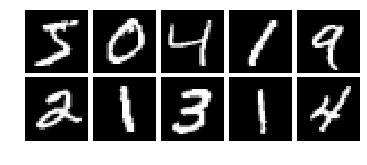

In [0]:
plot_mat(mnist_full_train_data[:10, None], cmap='gray')

In [0]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

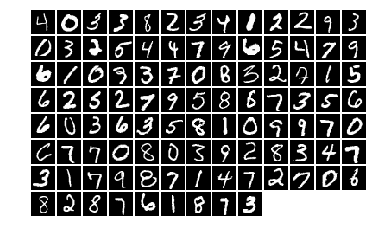

In [0]:
train_loader = InMemDataLoader(
    (mnist_full_train_data, ), batch_size=100, shuffle=True)
test_loader = InMemDataLoader(
    (mnist_test_data, ), batch_size=100, shuffle=False)

batch_x, = next(iter(train_loader))
plot_mat(batch_x.numpy()[:,None,:,:], cmap='gray')

In [0]:
# Hyperparams

inp_dim = batch_x.shape[1:]
g_hid_dim = 500
d_hid_dim = 200
latent_dim = 20

class Generator(torch.nn.Module):
    """Takes an image and produces a latent vector."""
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, g_hid_dim)
        self.fc2 = nn.Linear(g_hid_dim, g_hid_dim)
        self.fc3 = nn.Linear(g_hid_dim, np.prod(inp_dim))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.view(-1, batch_x.size(1), batch_x.size(2))

class Discriminator(torch.nn.Module):
    """Takes an image and produces a latent vector."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(np.prod(inp_dim), d_hid_dim)
        self.fc2 = nn.Linear(d_hid_dim, d_hid_dim)
        self.fc3 = nn.Linear(d_hid_dim, 1)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        drop = self.dropout
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = drop(x)
        x = F.relu(self.fc2(x))
        x = drop(x)
        x = torch.sigmoid(self.fc3(x))
        return x

class GAN(torch.nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
    
    def d_loss(self, x):
        N = x.size(0)
        N2 = 2*N
        z = torch.rand((N, latent_dim), dtype=x.dtype, device=x.device)
        fakes = self.generator(z)
        batch = torch.cat((x, fakes), dim=0)
        probs = self.discriminator(batch)
        tprobs = probs[:N]
        fprobs = probs[N:]
        xent_loss = (tprobs.log().sum() + (1.0 - fprobs).log().sum()) / -N2
        acc = ((tprobs >= 0.5).float().sum() + (fprobs < 0.5).float().sum()) / N2
        stats = {'d_xent': xent_loss.item(), 'd_acc': acc.item()}
        return xent_loss, stats
    
    def g_loss(self, x, non_saturating=True):
        N = x.size(0)
        z = torch.rand((N, latent_dim), dtype=x.dtype, device=x.device)
        fakes = self.generator(z)
        probs = self.discriminator(fakes)
        if non_saturating:
            loss = - probs.log().mean()
        else:
            loss = (1.0 - probs).log().mean()
        stats = {'g_loss': loss.item(), 'g_mean_p': probs.mean().item()}
        return loss, stats, fakes

In [0]:
model = GAN()
d_optimizer = torch.optim.Adam(model.discriminator.parameters(),
                               lr=1e-4, weight_decay=1.0e-3)
g_optimizer = torch.optim.Adam(model.generator.parameters(),
                               lr=1e-4, weight_decay=0)
global_step = 0

global step: 1 d_loss: 0.693143 {'d_xent': 0.6931431293487549, 'd_acc': 0.4949999749660492}, g_loss 0.716267 {'g_mean_p': 0.4888911247253418, 'g_loss': 0.716266930103302}


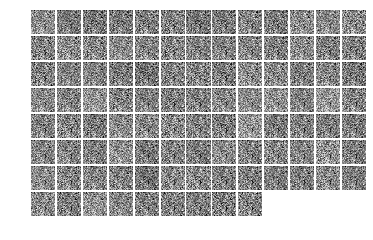

global step: 501 d_loss: 0.269981 {'d_xent': 0.2699805796146393, 'd_acc': 0.9099999666213989}, g_loss 2.133156 {'g_mean_p': 0.16853393614292145, 'g_loss': 2.133155584335327}


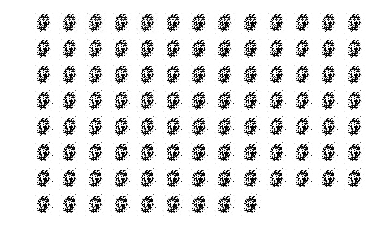

global step: 1001 d_loss: 0.266626 {'d_xent': 0.26662611961364746, 'd_acc': 0.9249999523162842}, g_loss 2.084650 {'g_mean_p': 0.15734410285949707, 'g_loss': 2.0846500396728516}


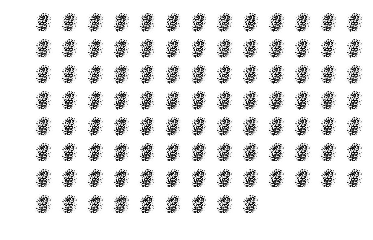

global step: 1501 d_loss: 0.293440 {'d_xent': 0.29343974590301514, 'd_acc': 0.8949999809265137}, g_loss 2.235134 {'g_mean_p': 0.16674309968948364, 'g_loss': 2.2351338863372803}


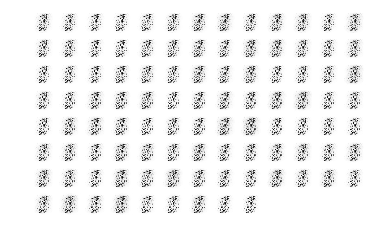

global step: 2001 d_loss: 0.104835 {'d_xent': 0.10483460873365402, 'd_acc': 0.9799999594688416}, g_loss 2.641015 {'g_mean_p': 0.09216456115245819, 'g_loss': 2.6410152912139893}


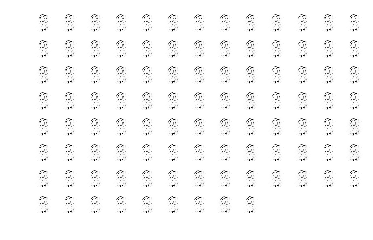

global step: 2501 d_loss: 0.081853 {'d_xent': 0.08185277134180069, 'd_acc': 0.9749999642372131}, g_loss 3.486073 {'g_mean_p': 0.04667205363512039, 'g_loss': 3.4860732555389404}


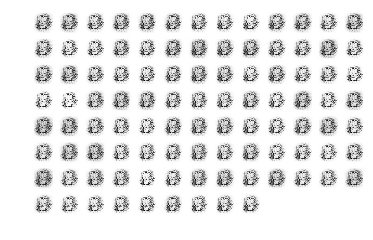

global step: 3001 d_loss: 0.051705 {'d_xent': 0.05170451104640961, 'd_acc': 0.9950000047683716}, g_loss 4.074062 {'g_mean_p': 0.03678380325436592, 'g_loss': 4.074061870574951}


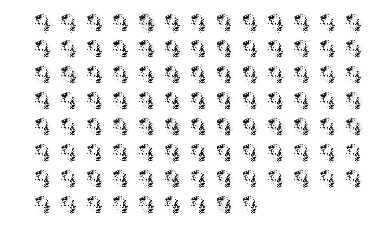

global step: 3501 d_loss: 0.040983 {'d_xent': 0.04098282754421234, 'd_acc': 0.98499995470047}, g_loss 5.290343 {'g_mean_p': 0.012415801174938679, 'g_loss': 5.290343284606934}


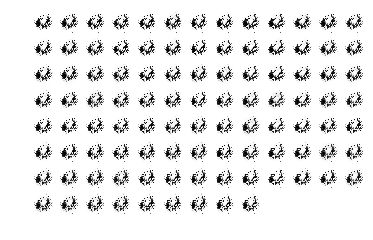

global step: 4001 d_loss: 0.103278 {'d_xent': 0.10327810049057007, 'd_acc': 0.9649999737739563}, g_loss 3.185368 {'g_mean_p': 0.061418984085321426, 'g_loss': 3.1853675842285156}


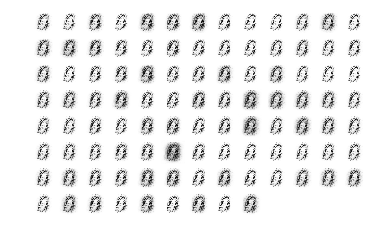

global step: 4501 d_loss: 0.075662 {'d_xent': 0.07566181570291519, 'd_acc': 0.9749999642372131}, g_loss 3.801065 {'g_mean_p': 0.03691387176513672, 'g_loss': 3.80106520652771}


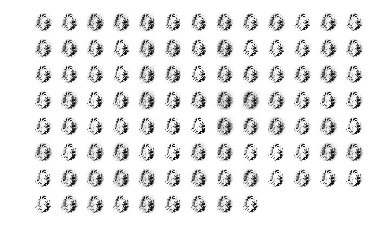

global step: 5001 d_loss: 0.070088 {'d_xent': 0.07008842378854752, 'd_acc': 0.98499995470047}, g_loss 3.948212 {'g_mean_p': 0.026106033474206924, 'g_loss': 3.948211908340454}


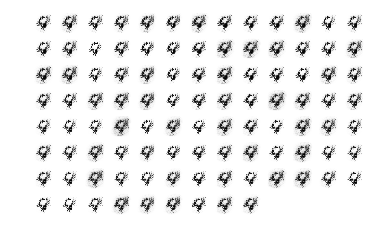

global step: 5501 d_loss: 0.056191 {'d_xent': 0.0561906099319458, 'd_acc': 0.9799999594688416}, g_loss 3.412735 {'g_mean_p': 0.04033640772104263, 'g_loss': 3.4127345085144043}


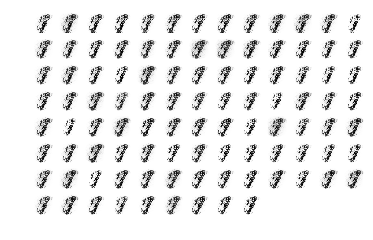

global step: 6001 d_loss: 0.036498 {'d_xent': 0.03649811074137688, 'd_acc': 0.9899999499320984}, g_loss 3.957525 {'g_mean_p': 0.027436422184109688, 'g_loss': 3.9575254917144775}


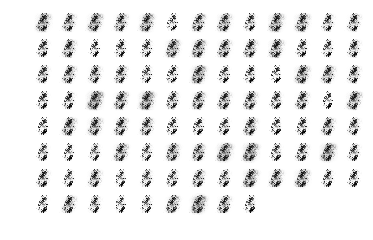

global step: 6501 d_loss: 0.042650 {'d_xent': 0.042650360614061356, 'd_acc': 0.9899999499320984}, g_loss 5.493309 {'g_mean_p': 0.012479816563427448, 'g_loss': 5.493309020996094}


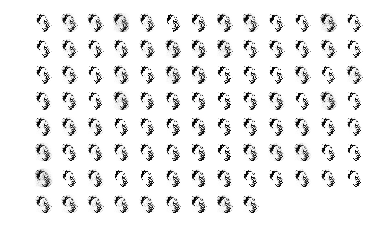

global step: 7001 d_loss: 0.074524 {'d_xent': 0.0745244175195694, 'd_acc': 0.9799999594688416}, g_loss 4.225202 {'g_mean_p': 0.026143545284867287, 'g_loss': 4.2252020835876465}


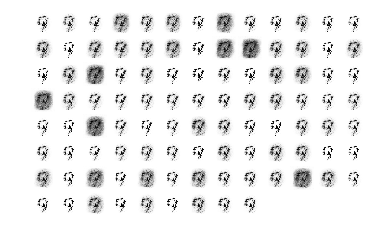

global step: 7501 d_loss: 0.027388 {'d_xent': 0.02738763764500618, 'd_acc': 0.9950000047683716}, g_loss 4.106635 {'g_mean_p': 0.030246738344430923, 'g_loss': 4.106634616851807}


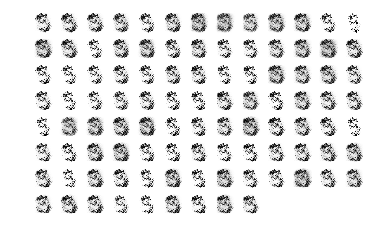

global step: 8001 d_loss: 0.134855 {'d_xent': 0.13485528528690338, 'd_acc': 0.9549999833106995}, g_loss 3.818872 {'g_mean_p': 0.05062749609351158, 'g_loss': 3.8188717365264893}


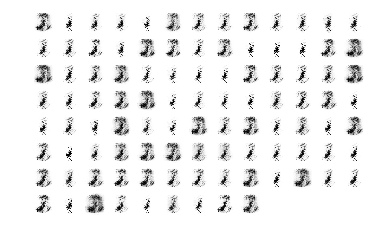

global step: 8501 d_loss: 0.111853 {'d_xent': 0.1118527352809906, 'd_acc': 0.9699999690055847}, g_loss 4.104628 {'g_mean_p': 0.033660173416137695, 'g_loss': 4.10462760925293}


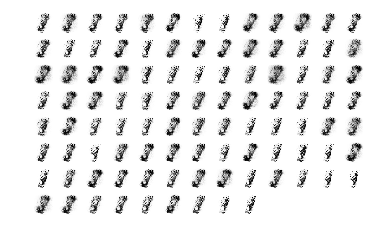

global step: 9001 d_loss: 0.089570 {'d_xent': 0.08956996351480484, 'd_acc': 0.9699999690055847}, g_loss 4.029281 {'g_mean_p': 0.040481384843587875, 'g_loss': 4.029280662536621}


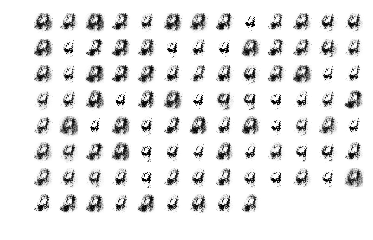

global step: 9501 d_loss: 0.080919 {'d_xent': 0.08091900497674942, 'd_acc': 0.9749999642372131}, g_loss 3.649232 {'g_mean_p': 0.04555412754416466, 'g_loss': 3.6492323875427246}


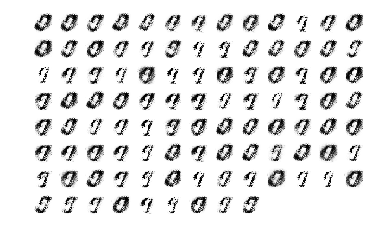

global step: 10001 d_loss: 0.057082 {'d_xent': 0.05708181858062744, 'd_acc': 0.9749999642372131}, g_loss 4.286673 {'g_mean_p': 0.04080934077501297, 'g_loss': 4.286673069000244}


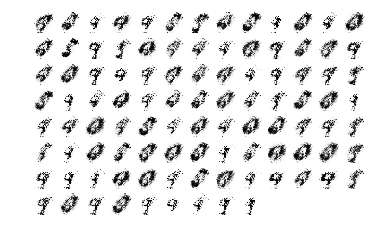

global step: 10501 d_loss: 0.111767 {'d_xent': 0.11176708340644836, 'd_acc': 0.9649999737739563}, g_loss 3.641186 {'g_mean_p': 0.04980536177754402, 'g_loss': 3.6411855220794678}


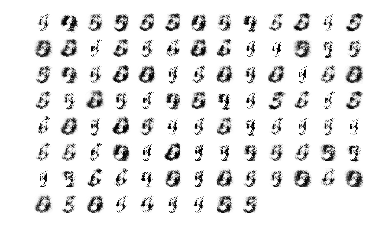

global step: 11001 d_loss: 0.109939 {'d_xent': 0.10993904620409012, 'd_acc': 0.9649999737739563}, g_loss 3.326270 {'g_mean_p': 0.07011488080024719, 'g_loss': 3.32627010345459}


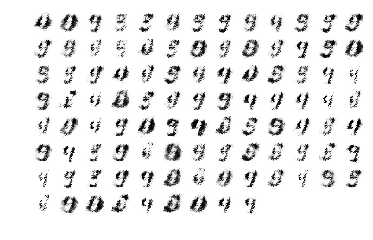

global step: 11501 d_loss: 0.083469 {'d_xent': 0.08346892148256302, 'd_acc': 0.9599999785423279}, g_loss 3.969282 {'g_mean_p': 0.059078529477119446, 'g_loss': 3.969282388687134}


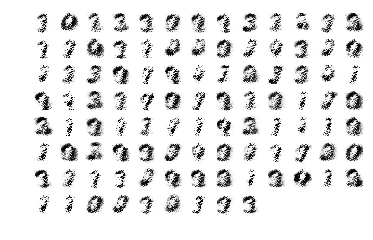

global step: 12001 d_loss: 0.129218 {'d_xent': 0.12921841442584991, 'd_acc': 0.9449999928474426}, g_loss 3.629399 {'g_mean_p': 0.053945764899253845, 'g_loss': 3.629399299621582}


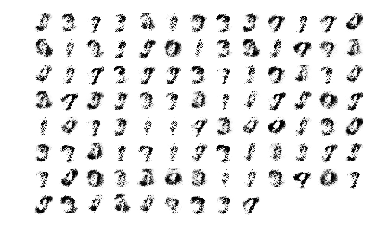

global step: 12501 d_loss: 0.050200 {'d_xent': 0.05019965395331383, 'd_acc': 0.98499995470047}, g_loss 3.845810 {'g_mean_p': 0.04055037721991539, 'g_loss': 3.8458104133605957}


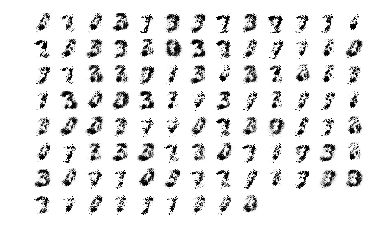

global step: 13001 d_loss: 0.063311 {'d_xent': 0.06331110000610352, 'd_acc': 0.9749999642372131}, g_loss 3.497582 {'g_mean_p': 0.05866699665784836, 'g_loss': 3.497581720352173}


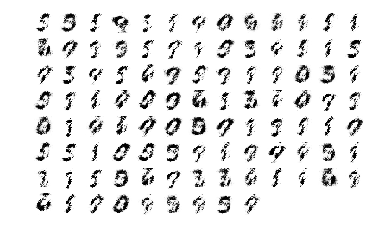

global step: 13501 d_loss: 0.135729 {'d_xent': 0.13572899997234344, 'd_acc': 0.9599999785423279}, g_loss 2.997009 {'g_mean_p': 0.07907363027334213, 'g_loss': 2.99700927734375}


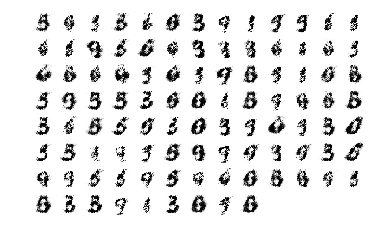

global step: 14001 d_loss: 0.126578 {'d_xent': 0.12657833099365234, 'd_acc': 0.9599999785423279}, g_loss 4.923111 {'g_mean_p': 0.03811031952500343, 'g_loss': 4.9231109619140625}


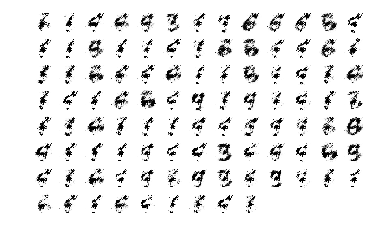

global step: 14501 d_loss: 0.113483 {'d_xent': 0.11348322778940201, 'd_acc': 0.9599999785423279}, g_loss 4.804286 {'g_mean_p': 0.019496051594614983, 'g_loss': 4.804285526275635}


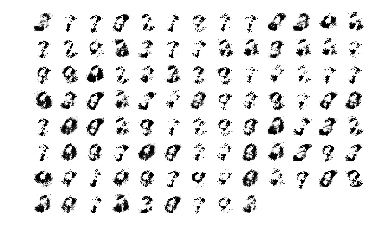

global step: 15001 d_loss: 0.165484 {'d_xent': 0.16548430919647217, 'd_acc': 0.9449999928474426}, g_loss 3.632233 {'g_mean_p': 0.12085551768541336, 'g_loss': 3.6322333812713623}


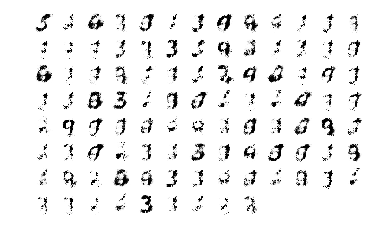

global step: 15501 d_loss: 0.062508 {'d_xent': 0.0625080019235611, 'd_acc': 0.98499995470047}, g_loss 3.485881 {'g_mean_p': 0.05372500792145729, 'g_loss': 3.4858808517456055}


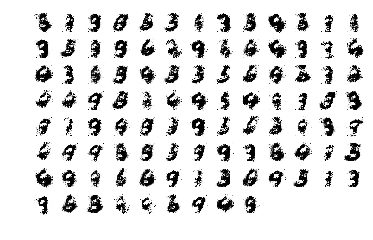

global step: 16001 d_loss: 0.100993 {'d_xent': 0.10099346190690994, 'd_acc': 0.9599999785423279}, g_loss 3.461277 {'g_mean_p': 0.12211275845766068, 'g_loss': 3.461277484893799}


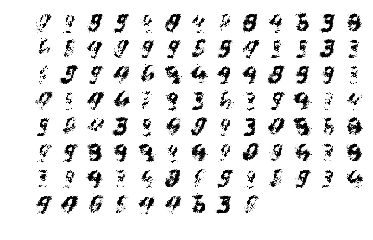

global step: 16501 d_loss: 0.109111 {'d_xent': 0.10911120474338531, 'd_acc': 0.949999988079071}, g_loss 4.423239 {'g_mean_p': 0.034419141709804535, 'g_loss': 4.423239231109619}


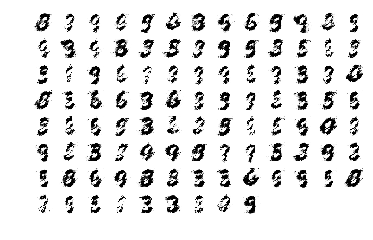

global step: 17001 d_loss: 0.044239 {'d_xent': 0.044239357113838196, 'd_acc': 0.9899999499320984}, g_loss 3.890377 {'g_mean_p': 0.040609125047922134, 'g_loss': 3.8903770446777344}


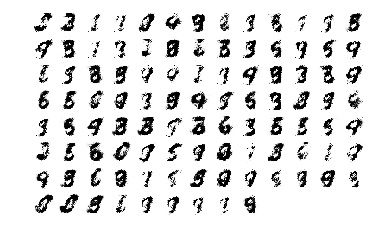

global step: 17501 d_loss: 0.171359 {'d_xent': 0.17135947942733765, 'd_acc': 0.9449999928474426}, g_loss 4.564408 {'g_mean_p': 0.05675952136516571, 'g_loss': 4.564407825469971}


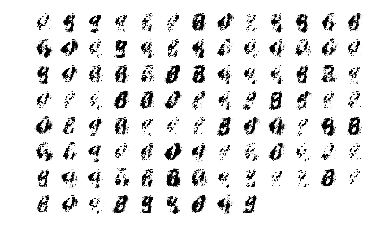

global step: 18001 d_loss: 0.115801 {'d_xent': 0.11580055207014084, 'd_acc': 0.9649999737739563}, g_loss 3.845784 {'g_mean_p': 0.04992089793086052, 'g_loss': 3.8457844257354736}


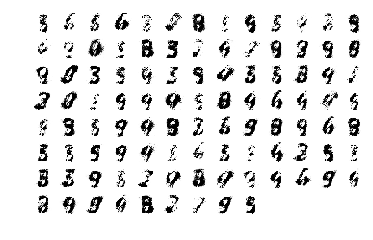

global step: 18501 d_loss: 0.052542 {'d_xent': 0.05254170298576355, 'd_acc': 0.9950000047683716}, g_loss 3.618926 {'g_mean_p': 0.044341254979372025, 'g_loss': 3.6189262866973877}


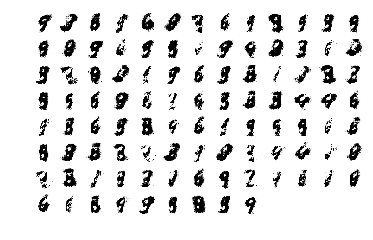

global step: 19001 d_loss: 0.108528 {'d_xent': 0.10852770507335663, 'd_acc': 0.949999988079071}, g_loss 3.794163 {'g_mean_p': 0.05987268313765526, 'g_loss': 3.794163227081299}


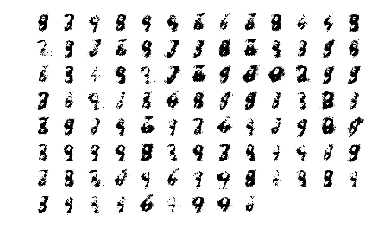

global step: 19501 d_loss: 0.132154 {'d_xent': 0.1321544200181961, 'd_acc': 0.9399999976158142}, g_loss 3.632379 {'g_mean_p': 0.06922561675310135, 'g_loss': 3.6323792934417725}


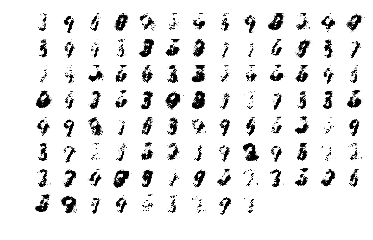

global step: 20001 d_loss: 0.103325 {'d_xent': 0.10332523286342621, 'd_acc': 0.9699999690055847}, g_loss 3.981065 {'g_mean_p': 0.06455852091312408, 'g_loss': 3.981065034866333}


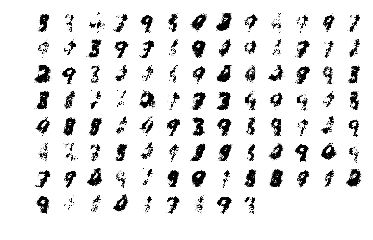

global step: 20501 d_loss: 0.108749 {'d_xent': 0.10874947905540466, 'd_acc': 0.9599999785423279}, g_loss 4.269608 {'g_mean_p': 0.06571131199598312, 'g_loss': 4.269608020782471}


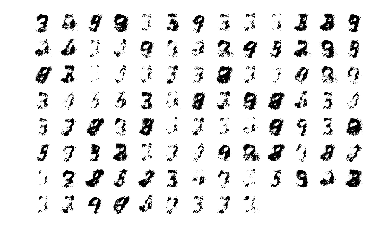

global step: 21001 d_loss: 0.121570 {'d_xent': 0.12156996130943298, 'd_acc': 0.9549999833106995}, g_loss 3.148362 {'g_mean_p': 0.07517850399017334, 'g_loss': 3.1483616828918457}


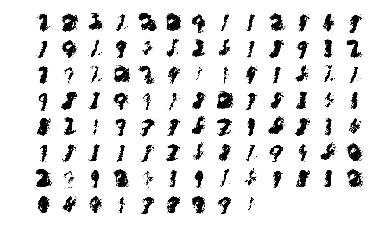

global step: 21501 d_loss: 0.073796 {'d_xent': 0.0737961083650589, 'd_acc': 0.9799999594688416}, g_loss 3.471281 {'g_mean_p': 0.05174912512302399, 'g_loss': 3.471281051635742}


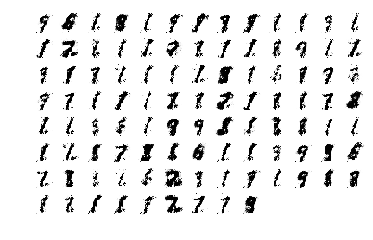

global step: 22001 d_loss: 0.122761 {'d_xent': 0.12276119738817215, 'd_acc': 0.9449999928474426}, g_loss 3.268301 {'g_mean_p': 0.07670392841100693, 'g_loss': 3.268301248550415}


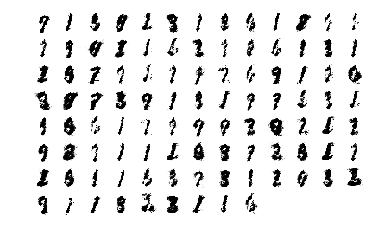

global step: 22501 d_loss: 0.081645 {'d_xent': 0.08164454251527786, 'd_acc': 0.9749999642372131}, g_loss 3.540743 {'g_mean_p': 0.07000482082366943, 'g_loss': 3.5407426357269287}


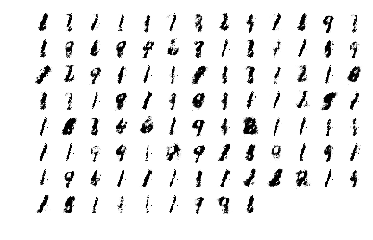

global step: 23001 d_loss: 0.140385 {'d_xent': 0.14038491249084473, 'd_acc': 0.9549999833106995}, g_loss 3.273866 {'g_mean_p': 0.06476373970508575, 'g_loss': 3.2738664150238037}


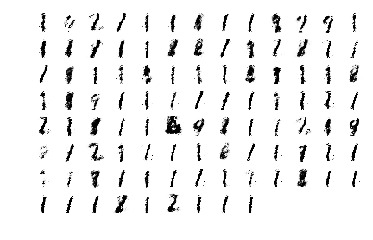

global step: 23501 d_loss: 0.086142 {'d_xent': 0.08614248037338257, 'd_acc': 0.9699999690055847}, g_loss 2.943620 {'g_mean_p': 0.07573343813419342, 'g_loss': 2.943619966506958}


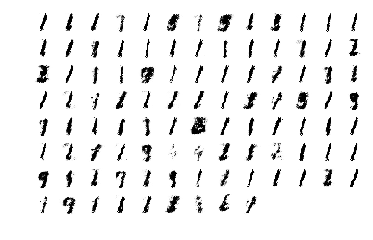

global step: 24001 d_loss: 0.138674 {'d_xent': 0.13867443799972534, 'd_acc': 0.949999988079071}, g_loss 3.078262 {'g_mean_p': 0.0738077238202095, 'g_loss': 3.0782618522644043}


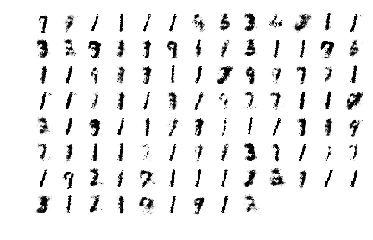

global step: 24501 d_loss: 0.272618 {'d_xent': 0.27261829376220703, 'd_acc': 0.8899999856948853}, g_loss 2.588313 {'g_mean_p': 0.12226806581020355, 'g_loss': 2.588312864303589}


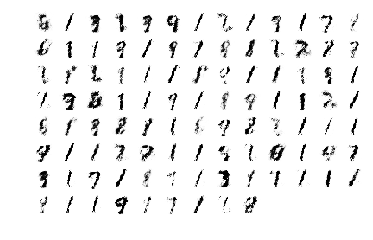

global step: 25001 d_loss: 0.172253 {'d_xent': 0.17225287854671478, 'd_acc': 0.9350000023841858}, g_loss 2.455344 {'g_mean_p': 0.13571688532829285, 'g_loss': 2.4553444385528564}


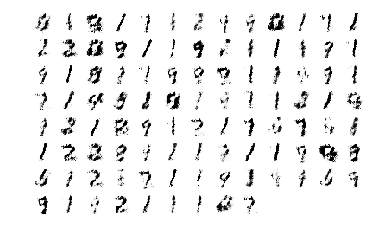

global step: 25501 d_loss: 0.248776 {'d_xent': 0.24877627193927765, 'd_acc': 0.9149999618530273}, g_loss 2.822670 {'g_mean_p': 0.09821148961782455, 'g_loss': 2.8226699829101562}


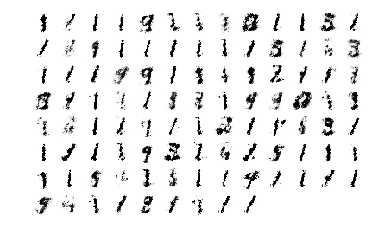

global step: 26001 d_loss: 0.165453 {'d_xent': 0.16545292735099792, 'd_acc': 0.9300000071525574}, g_loss 2.469400 {'g_mean_p': 0.13557714223861694, 'g_loss': 2.4693996906280518}


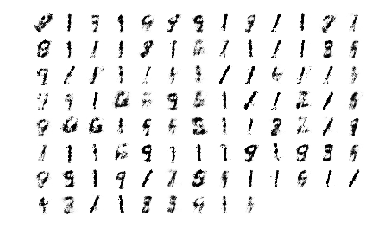

global step: 26501 d_loss: 0.260167 {'d_xent': 0.2601666748523712, 'd_acc': 0.8999999761581421}, g_loss 2.612933 {'g_mean_p': 0.15319427847862244, 'g_loss': 2.6129326820373535}


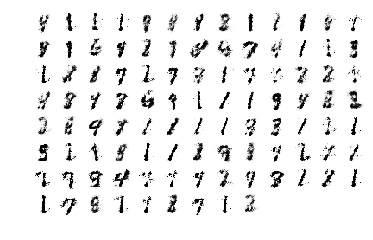

global step: 27001 d_loss: 0.243994 {'d_xent': 0.2439938634634018, 'd_acc': 0.8999999761581421}, g_loss 2.547627 {'g_mean_p': 0.14462190866470337, 'g_loss': 2.5476272106170654}


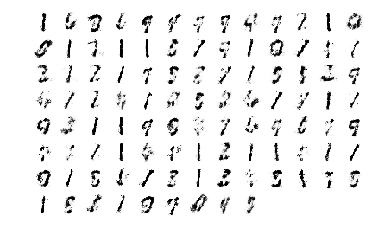

global step: 27501 d_loss: 0.238626 {'d_xent': 0.2386258989572525, 'd_acc': 0.9099999666213989}, g_loss 2.305283 {'g_mean_p': 0.15920434892177582, 'g_loss': 2.3052825927734375}


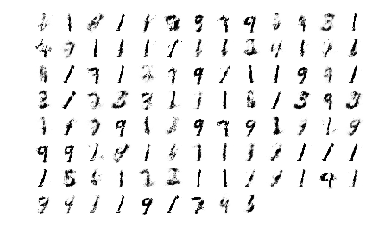

global step: 28001 d_loss: 0.265609 {'d_xent': 0.2656085193157196, 'd_acc': 0.9049999713897705}, g_loss 2.193115 {'g_mean_p': 0.1899959295988083, 'g_loss': 2.193115472793579}


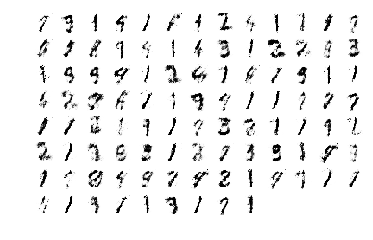

global step: 28501 d_loss: 0.268231 {'d_xent': 0.26823118329048157, 'd_acc': 0.8899999856948853}, g_loss 2.498137 {'g_mean_p': 0.12131817638874054, 'g_loss': 2.4981369972229004}


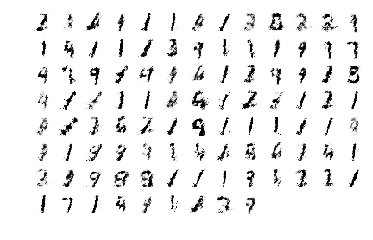

global step: 29001 d_loss: 0.295335 {'d_xent': 0.29533541202545166, 'd_acc': 0.8700000047683716}, g_loss 2.000816 {'g_mean_p': 0.21592044830322266, 'g_loss': 2.0008161067962646}


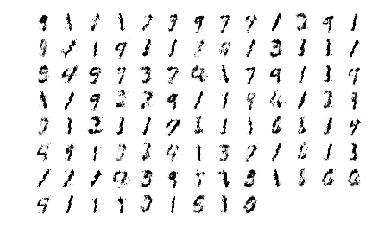

global step: 29501 d_loss: 0.249159 {'d_xent': 0.2491590827703476, 'd_acc': 0.8949999809265137}, g_loss 2.508034 {'g_mean_p': 0.1278555989265442, 'g_loss': 2.5080342292785645}


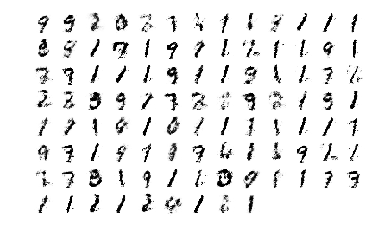

global step: 30001 d_loss: 0.291451 {'d_xent': 0.29145145416259766, 'd_acc': 0.8899999856948853}, g_loss 2.192796 {'g_mean_p': 0.15574757754802704, 'g_loss': 2.192795991897583}


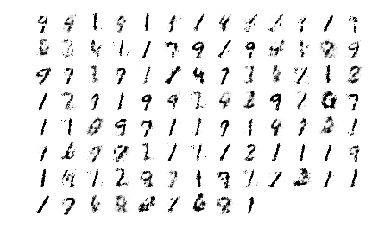

global step: 30501 d_loss: 0.248045 {'d_xent': 0.24804483354091644, 'd_acc': 0.9049999713897705}, g_loss 2.350768 {'g_mean_p': 0.14314770698547363, 'g_loss': 2.3507678508758545}


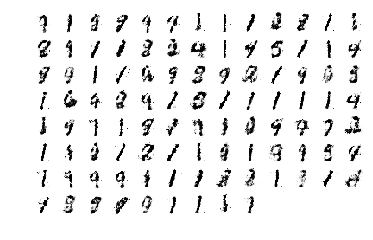

global step: 31001 d_loss: 0.326314 {'d_xent': 0.32631391286849976, 'd_acc': 0.8499999642372131}, g_loss 1.867042 {'g_mean_p': 0.22344811260700226, 'g_loss': 1.8670421838760376}


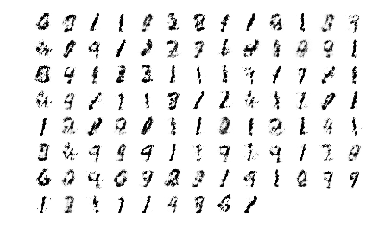

global step: 31501 d_loss: 0.289114 {'d_xent': 0.2891140282154083, 'd_acc': 0.8899999856948853}, g_loss 2.124632 {'g_mean_p': 0.18435029685497284, 'g_loss': 2.124631881713867}


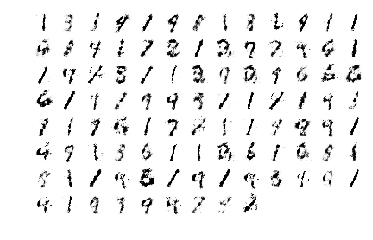

global step: 32001 d_loss: 0.253438 {'d_xent': 0.2534383237361908, 'd_acc': 0.8899999856948853}, g_loss 2.088893 {'g_mean_p': 0.1743476241827011, 'g_loss': 2.088892936706543}


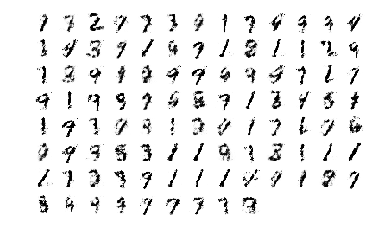

global step: 32501 d_loss: 0.311631 {'d_xent': 0.31163132190704346, 'd_acc': 0.875}, g_loss 2.214257 {'g_mean_p': 0.16712762415409088, 'g_loss': 2.214256763458252}


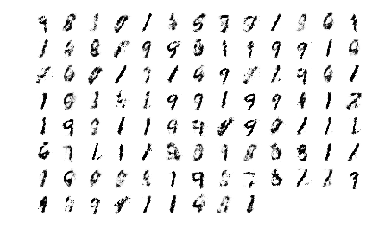

global step: 33001 d_loss: 0.311612 {'d_xent': 0.3116115629673004, 'd_acc': 0.875}, g_loss 2.105279 {'g_mean_p': 0.17568857967853546, 'g_loss': 2.105278730392456}


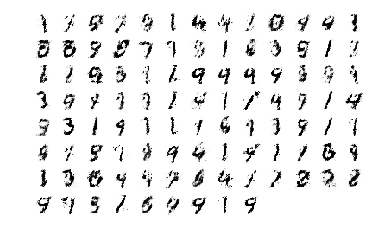

global step: 33501 d_loss: 0.254346 {'d_xent': 0.25434643030166626, 'd_acc': 0.8799999952316284}, g_loss 2.187339 {'g_mean_p': 0.1554548740386963, 'g_loss': 2.1873393058776855}


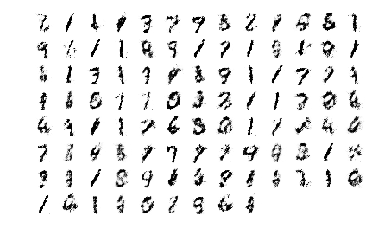

global step: 34001 d_loss: 0.274786 {'d_xent': 0.2747856080532074, 'd_acc': 0.8999999761581421}, g_loss 2.121705 {'g_mean_p': 0.1891435980796814, 'g_loss': 2.1217048168182373}


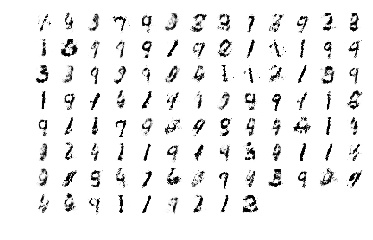

global step: 34501 d_loss: 0.329520 {'d_xent': 0.32952049374580383, 'd_acc': 0.8849999904632568}, g_loss 2.164566 {'g_mean_p': 0.18495424091815948, 'g_loss': 2.1645658016204834}


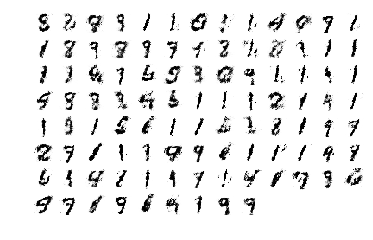

global step: 35001 d_loss: 0.296290 {'d_xent': 0.2962903678417206, 'd_acc': 0.8999999761581421}, g_loss 1.863915 {'g_mean_p': 0.1980222910642624, 'g_loss': 1.8639150857925415}


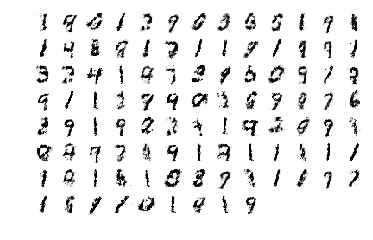

global step: 35501 d_loss: 0.248460 {'d_xent': 0.24845950305461884, 'd_acc': 0.8899999856948853}, g_loss 2.227468 {'g_mean_p': 0.1491376906633377, 'g_loss': 2.2274675369262695}


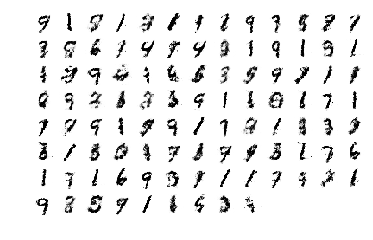

global step: 36001 d_loss: 0.286997 {'d_xent': 0.2869968116283417, 'd_acc': 0.8899999856948853}, g_loss 2.164482 {'g_mean_p': 0.15945053100585938, 'g_loss': 2.1644821166992188}


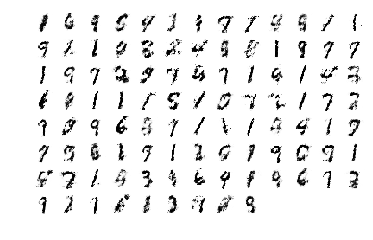

global step: 36501 d_loss: 0.322521 {'d_xent': 0.3225208520889282, 'd_acc': 0.8449999690055847}, g_loss 2.059055 {'g_mean_p': 0.1922854334115982, 'g_loss': 2.0590553283691406}


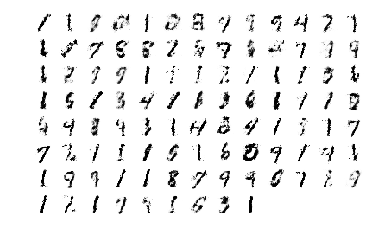

global step: 37001 d_loss: 0.280713 {'d_xent': 0.2807130515575409, 'd_acc': 0.85999995470047}, g_loss 1.944788 {'g_mean_p': 0.18473942577838898, 'g_loss': 1.9447879791259766}


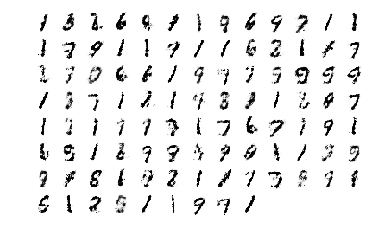

global step: 37501 d_loss: 0.265386 {'d_xent': 0.2653856873512268, 'd_acc': 0.8949999809265137}, g_loss 1.946911 {'g_mean_p': 0.22159284353256226, 'g_loss': 1.9469108581542969}


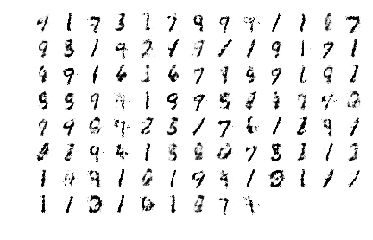

global step: 38001 d_loss: 0.324083 {'d_xent': 0.32408255338668823, 'd_acc': 0.8650000095367432}, g_loss 1.715096 {'g_mean_p': 0.23606668412685394, 'g_loss': 1.715096116065979}


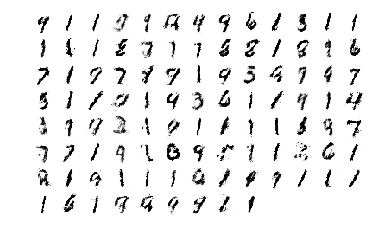

global step: 38501 d_loss: 0.325500 {'d_xent': 0.32550048828125, 'd_acc': 0.8399999737739563}, g_loss 2.101062 {'g_mean_p': 0.1643449366092682, 'g_loss': 2.1010618209838867}


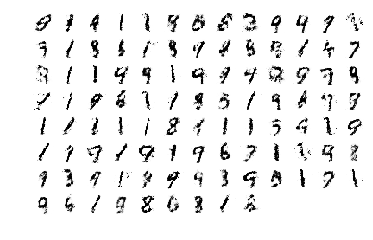

global step: 39001 d_loss: 0.294604 {'d_xent': 0.29460400342941284, 'd_acc': 0.8799999952316284}, g_loss 1.941191 {'g_mean_p': 0.1961498260498047, 'g_loss': 1.9411910772323608}


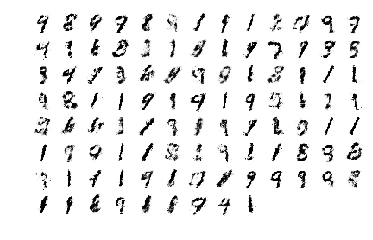

global step: 39501 d_loss: 0.308581 {'d_xent': 0.30858108401298523, 'd_acc': 0.8799999952316284}, g_loss 1.908602 {'g_mean_p': 0.19255490601062775, 'g_loss': 1.9086017608642578}


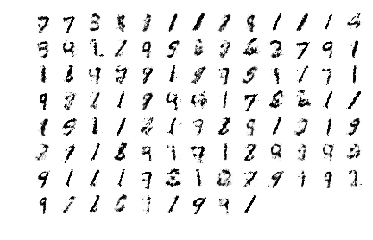

global step: 40001 d_loss: 0.345812 {'d_xent': 0.3458118736743927, 'd_acc': 0.8549999594688416}, g_loss 1.992088 {'g_mean_p': 0.18129277229309082, 'g_loss': 1.9920883178710938}


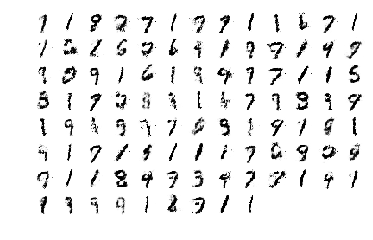

global step: 40501 d_loss: 0.254862 {'d_xent': 0.2548619508743286, 'd_acc': 0.9099999666213989}, g_loss 1.805613 {'g_mean_p': 0.22069713473320007, 'g_loss': 1.8056128025054932}


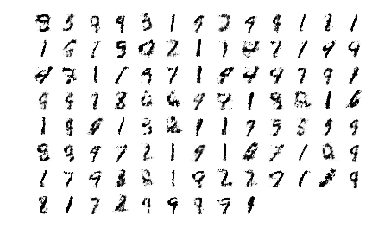

global step: 41001 d_loss: 0.337976 {'d_xent': 0.33797648549079895, 'd_acc': 0.8399999737739563}, g_loss 1.817586 {'g_mean_p': 0.23624546825885773, 'g_loss': 1.8175857067108154}


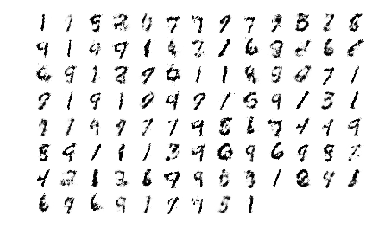

global step: 41501 d_loss: 0.300362 {'d_xent': 0.300361692905426, 'd_acc': 0.85999995470047}, g_loss 2.096967 {'g_mean_p': 0.17731209099292755, 'g_loss': 2.0969672203063965}


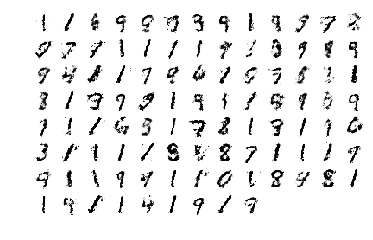

global step: 42001 d_loss: 0.346882 {'d_xent': 0.3468824028968811, 'd_acc': 0.8499999642372131}, g_loss 1.961621 {'g_mean_p': 0.20606239140033722, 'g_loss': 1.9616210460662842}


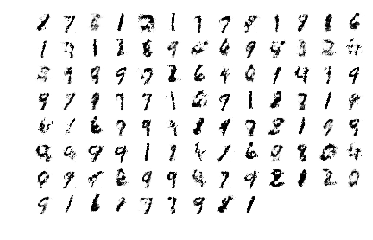

global step: 42501 d_loss: 0.362960 {'d_xent': 0.362959623336792, 'd_acc': 0.85999995470047}, g_loss 1.831470 {'g_mean_p': 0.22545188665390015, 'g_loss': 1.831470251083374}


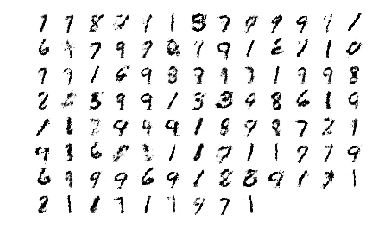

global step: 43001 d_loss: 0.397395 {'d_xent': 0.39739474654197693, 'd_acc': 0.8199999928474426}, g_loss 1.887917 {'g_mean_p': 0.20130015909671783, 'g_loss': 1.8879165649414062}


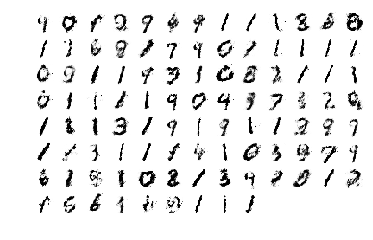

global step: 43501 d_loss: 0.349510 {'d_xent': 0.34950998425483704, 'd_acc': 0.8449999690055847}, g_loss 1.719595 {'g_mean_p': 0.247257262468338, 'g_loss': 1.719595193862915}


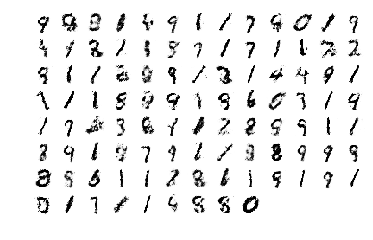

global step: 44001 d_loss: 0.325966 {'d_xent': 0.3259661793708801, 'd_acc': 0.8650000095367432}, g_loss 1.805262 {'g_mean_p': 0.2109157294034958, 'g_loss': 1.8052619695663452}


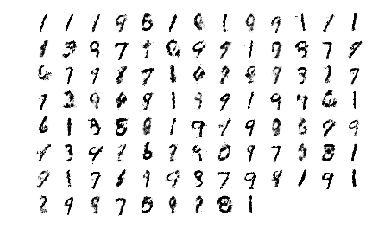

global step: 44501 d_loss: 0.275851 {'d_xent': 0.27585121989250183, 'd_acc': 0.8999999761581421}, g_loss 1.742002 {'g_mean_p': 0.2302422672510147, 'g_loss': 1.7420024871826172}


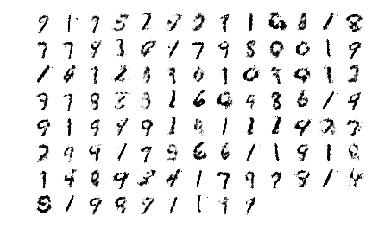

global step: 45001 d_loss: 0.313157 {'d_xent': 0.31315720081329346, 'd_acc': 0.8799999952316284}, g_loss 1.813643 {'g_mean_p': 0.22000737488269806, 'g_loss': 1.8136425018310547}


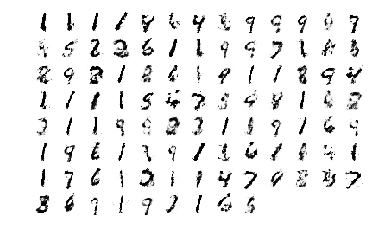

global step: 45501 d_loss: 0.334772 {'d_xent': 0.3347715735435486, 'd_acc': 0.8449999690055847}, g_loss 1.889944 {'g_mean_p': 0.21532848477363586, 'g_loss': 1.8899439573287964}


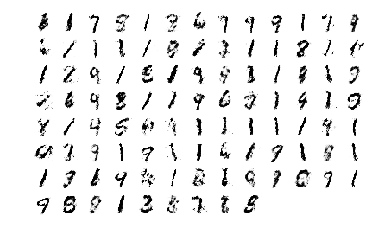

global step: 46001 d_loss: 0.355149 {'d_xent': 0.3551488518714905, 'd_acc': 0.8399999737739563}, g_loss 1.925077 {'g_mean_p': 0.19126561284065247, 'g_loss': 1.9250766038894653}


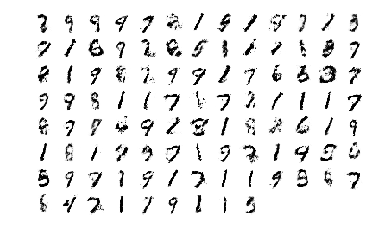

global step: 46501 d_loss: 0.325253 {'d_xent': 0.3252534866333008, 'd_acc': 0.875}, g_loss 1.798878 {'g_mean_p': 0.22095681726932526, 'g_loss': 1.7988778352737427}


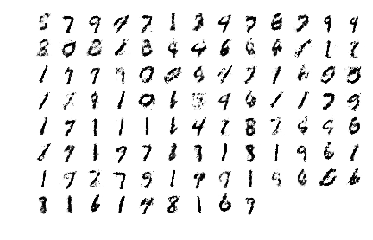

global step: 47001 d_loss: 0.339267 {'d_xent': 0.3392665684223175, 'd_acc': 0.8299999833106995}, g_loss 1.689760 {'g_mean_p': 0.25922247767448425, 'g_loss': 1.689759612083435}


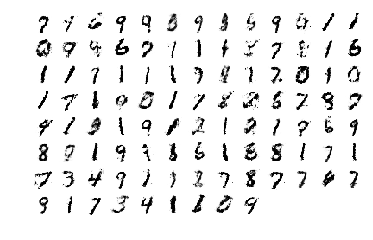

global step: 47501 d_loss: 0.366735 {'d_xent': 0.36673495173454285, 'd_acc': 0.8299999833106995}, g_loss 1.747779 {'g_mean_p': 0.2546592950820923, 'g_loss': 1.7477787733078003}


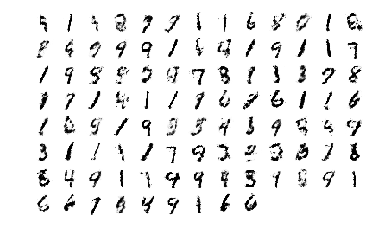

global step: 48001 d_loss: 0.339415 {'d_xent': 0.33941489458084106, 'd_acc': 0.875}, g_loss 1.771546 {'g_mean_p': 0.22675055265426636, 'g_loss': 1.7715461254119873}


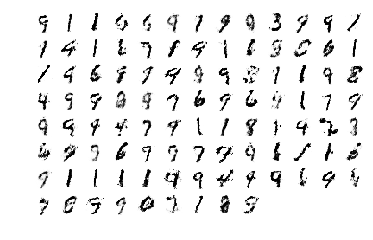

global step: 48501 d_loss: 0.374496 {'d_xent': 0.37449583411216736, 'd_acc': 0.7949999570846558}, g_loss 1.676531 {'g_mean_p': 0.2518311142921448, 'g_loss': 1.6765310764312744}


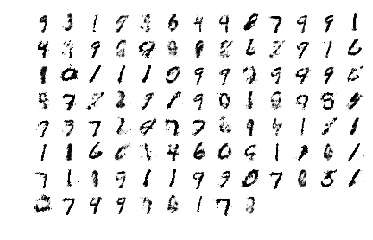

global step: 49001 d_loss: 0.376575 {'d_xent': 0.37657469511032104, 'd_acc': 0.8199999928474426}, g_loss 1.889750 {'g_mean_p': 0.21675613522529602, 'g_loss': 1.889749526977539}


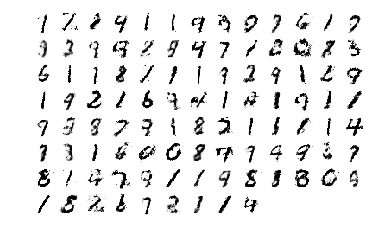

global step: 49501 d_loss: 0.351748 {'d_xent': 0.35174840688705444, 'd_acc': 0.8199999928474426}, g_loss 1.542651 {'g_mean_p': 0.2846538722515106, 'g_loss': 1.5426510572433472}


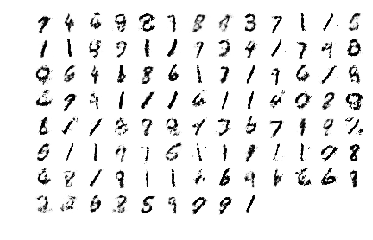

global step: 50001 d_loss: 0.391946 {'d_xent': 0.39194613695144653, 'd_acc': 0.8149999976158142}, g_loss 1.594138 {'g_mean_p': 0.257292240858078, 'g_loss': 1.5941375494003296}


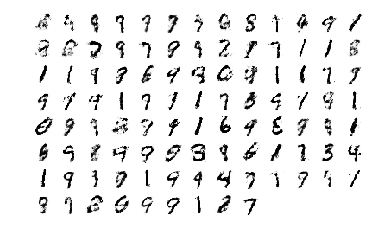

global step: 50501 d_loss: 0.400207 {'d_xent': 0.40020668506622314, 'd_acc': 0.8100000023841858}, g_loss 1.532510 {'g_mean_p': 0.27976375818252563, 'g_loss': 1.5325095653533936}


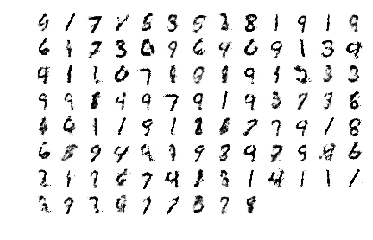

global step: 51001 d_loss: 0.351612 {'d_xent': 0.3516119420528412, 'd_acc': 0.8349999785423279}, g_loss 1.829853 {'g_mean_p': 0.21753264963626862, 'g_loss': 1.8298532962799072}


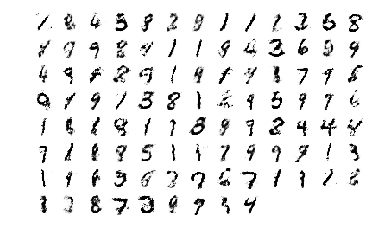

global step: 51501 d_loss: 0.448754 {'d_xent': 0.44875368475914, 'd_acc': 0.7699999809265137}, g_loss 1.742845 {'g_mean_p': 0.2233401983976364, 'g_loss': 1.742844820022583}


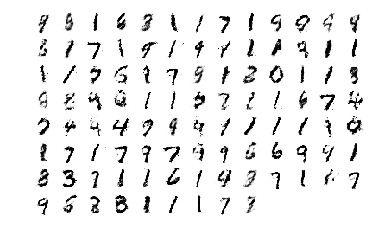

global step: 52001 d_loss: 0.417568 {'d_xent': 0.4175677001476288, 'd_acc': 0.8050000071525574}, g_loss 1.926621 {'g_mean_p': 0.20129701495170593, 'g_loss': 1.9266213178634644}


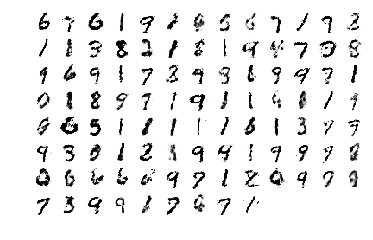

global step: 52501 d_loss: 0.380078 {'d_xent': 0.3800778090953827, 'd_acc': 0.8100000023841858}, g_loss 1.743783 {'g_mean_p': 0.23985056579113007, 'g_loss': 1.7437832355499268}


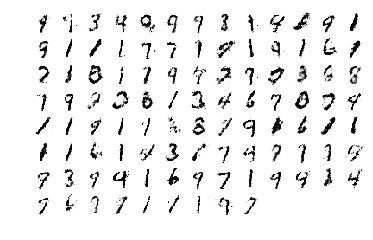

global step: 53001 d_loss: 0.357974 {'d_xent': 0.35797396302223206, 'd_acc': 0.8349999785423279}, g_loss 1.655482 {'g_mean_p': 0.2594391107559204, 'g_loss': 1.6554824113845825}


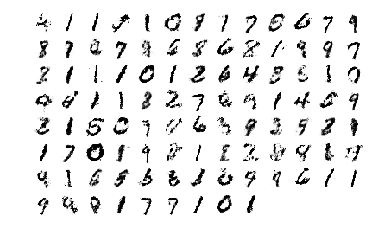

global step: 53501 d_loss: 0.391792 {'d_xent': 0.3917919099330902, 'd_acc': 0.8100000023841858}, g_loss 1.592720 {'g_mean_p': 0.2543775737285614, 'g_loss': 1.5927196741104126}


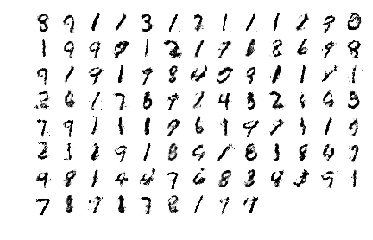

global step: 54001 d_loss: 0.407895 {'d_xent': 0.40789511799812317, 'd_acc': 0.7999999523162842}, g_loss 1.686914 {'g_mean_p': 0.23664352297782898, 'g_loss': 1.686914324760437}


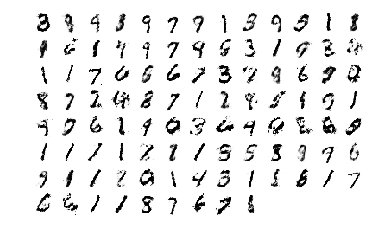

global step: 54501 d_loss: 0.346863 {'d_xent': 0.3468628525733948, 'd_acc': 0.8650000095367432}, g_loss 1.625221 {'g_mean_p': 0.2510342299938202, 'g_loss': 1.6252206563949585}


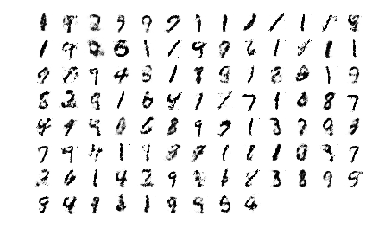

global step: 55001 d_loss: 0.385574 {'d_xent': 0.38557425141334534, 'd_acc': 0.8100000023841858}, g_loss 1.561281 {'g_mean_p': 0.2735341489315033, 'g_loss': 1.561281442642212}


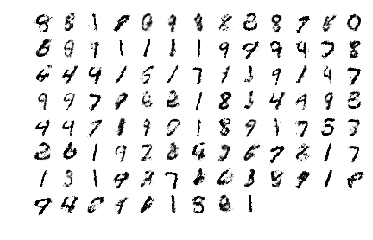

global step: 55501 d_loss: 0.375409 {'d_xent': 0.37540939450263977, 'd_acc': 0.8199999928474426}, g_loss 1.743713 {'g_mean_p': 0.24250495433807373, 'g_loss': 1.7437127828598022}


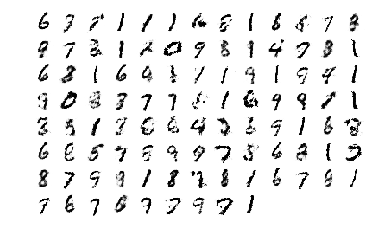

global step: 56001 d_loss: 0.305970 {'d_xent': 0.3059702217578888, 'd_acc': 0.875}, g_loss 1.649498 {'g_mean_p': 0.2515319287776947, 'g_loss': 1.6494975090026855}


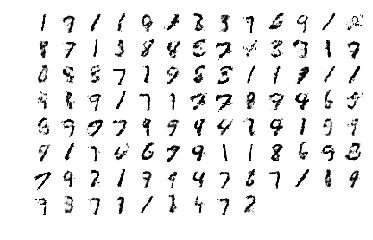

global step: 56501 d_loss: 0.405648 {'d_xent': 0.405648410320282, 'd_acc': 0.8149999976158142}, g_loss 1.605786 {'g_mean_p': 0.2519945204257965, 'g_loss': 1.6057860851287842}


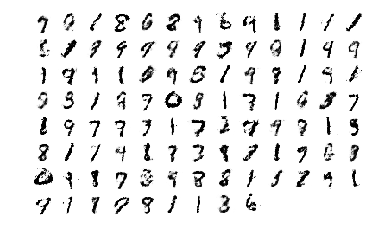

global step: 57001 d_loss: 0.333239 {'d_xent': 0.3332386314868927, 'd_acc': 0.8549999594688416}, g_loss 1.616636 {'g_mean_p': 0.25638532638549805, 'g_loss': 1.6166355609893799}


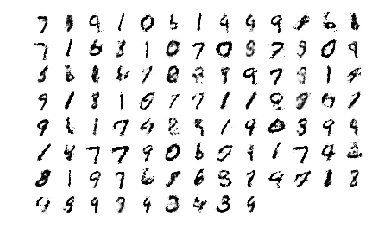

global step: 57501 d_loss: 0.411139 {'d_xent': 0.41113898158073425, 'd_acc': 0.8349999785423279}, g_loss 1.636941 {'g_mean_p': 0.2647264897823334, 'g_loss': 1.6369413137435913}


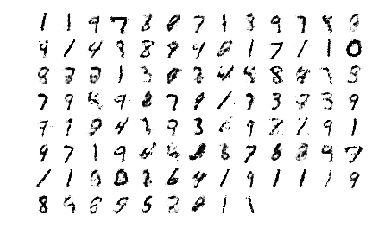

global step: 58001 d_loss: 0.409251 {'d_xent': 0.4092511236667633, 'd_acc': 0.8399999737739563}, g_loss 1.603873 {'g_mean_p': 0.25359201431274414, 'g_loss': 1.6038726568222046}


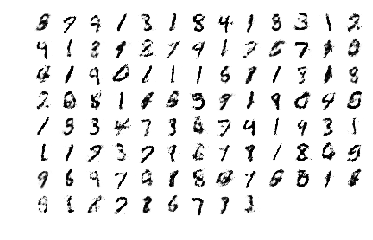

global step: 58501 d_loss: 0.424756 {'d_xent': 0.42475607991218567, 'd_acc': 0.824999988079071}, g_loss 1.494183 {'g_mean_p': 0.286291241645813, 'g_loss': 1.4941833019256592}


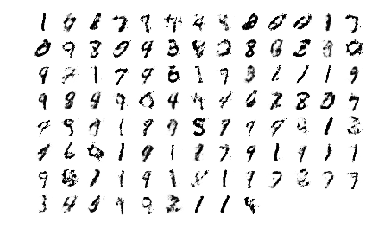

global step: 59001 d_loss: 0.358961 {'d_xent': 0.35896116495132446, 'd_acc': 0.824999988079071}, g_loss 1.549251 {'g_mean_p': 0.2668425440788269, 'g_loss': 1.5492513179779053}


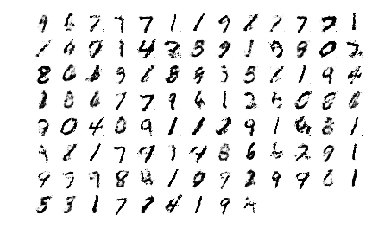

global step: 59501 d_loss: 0.358207 {'d_xent': 0.35820668935775757, 'd_acc': 0.8349999785423279}, g_loss 1.662013 {'g_mean_p': 0.23817700147628784, 'g_loss': 1.6620129346847534}


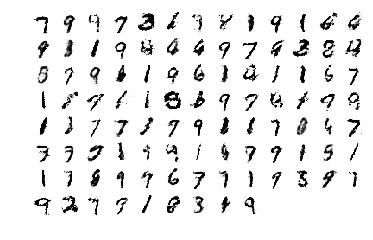

In [0]:
model.train()

model.to('cuda')
train_loader.to('cuda')

for epoch in range(100):
    for inum, (batch_x, ) in enumerate(train_loader):
        global_step += 1

        # D-step
        d_optimizer.zero_grad()
        d_loss, d_stats = model.d_loss(batch_x)
        d_loss.backward()
        d_optimizer.step()

        # G-step
        g_optimizer.zero_grad()
        g_loss, g_stats, g_fakes = model.g_loss(batch_x)
        g_loss.backward()
        g_optimizer.step()
        
        if (global_step%500) == 1:
            print("global step: %d d_loss: %f %s, g_loss %f %s" % 
                  (global_step, d_loss.item(), d_stats, g_loss.item(), g_stats))
            plot_mat(n(g_fakes)[:, None])
            plt.show()

## GAN analysis

Text(0.5,1,'Samples from a 20 dimensional GAN')

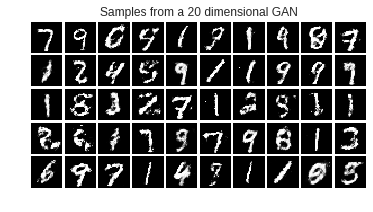

In [0]:
# Lets take a loook at samples generated from the GAN
#

z_rand = torch.rand(50, latent_dim, device=batch_x.device, dtype=batch_x.dtype)
samples = model.generator(z_rand).view(-1, 1, batch_x.size(1), batch_x.size(2))
plot_mat(n(samples), cmap='gray')
plt.title("Samples from a %d dimensional GAN" % latent_dim)

Text(0.5,1,'interpolation between two samples')

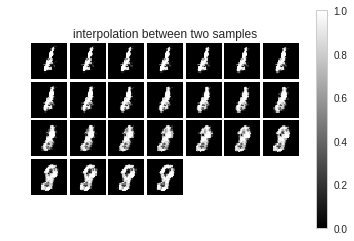

In [0]:
interp_weights = torch.linspace(
    0.0, 1.0, steps=25, dtype=torch.float32, device=batch_x.device).view(-1, 1)
k1, k2 = 2, 33
interp_z = interp_weights * z_rand[k1] + (1.0 - interp_weights) * z_rand[k2]
interp_recs = model.generator(interp_z).view(-1, 1, 28, 28)

plt.figure()
plot_mat(n(interp_recs), cmap='gray')
plt.colorbar()
plt.title('interpolation between two samples')

In [0]:
desired_img = batch_x[0:1]
infer_z = torch.rand((1, latent_dim), dtype=torch.float32, device='cuda', requires_grad=True)
z_optim = torch.optim.Adam([infer_z], lr=1e-1)

for step in range(5000):
    z_optim.zero_grad()
    def closure():
        img = model.generator(infer_z)
        loss = F.binary_cross_entropy(img, desired_img)
        if (step % 1000) == 0:
            print(step, loss.item())
        loss.backward()
        return loss
    z_optim.step(closure)
    with torch.no_grad():
        infer_z.clamp(0,1)
    

0 1.99075222015
1000 0.221433773637
2000 0.220703840256
3000 0.220719829202
4000 0.220783278346


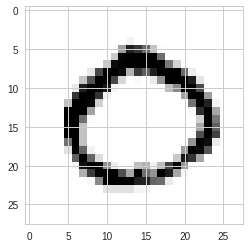

In [0]:
plt.imshow(n(batch_x[0:1])[0])

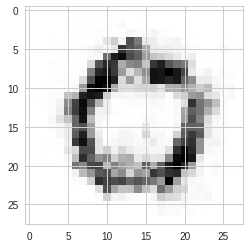

In [0]:
plt.imshow(n(model.generator(infer_z))[0])